In [1]:
import os
import shutil
import random
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.applications import VGG16
from keras import layers, models, Sequential
from keras.layers import Flatten, Dense, Rescaling


In [2]:
raw_data_dir = r"C:\Users\lenovo\OneDrive\Desktop\DL_Practical\caltech-101"

base_dir = r"C:\Users\lenovo\OneDrive\Desktop\DL_Practical\data_dir"
os.makedirs(base_dir, exist_ok=True)

for split in ['train', 'valid', 'test']:
    os.makedirs(os.path.join(base_dir, split), exist_ok=True)

# Split ratios
train_ratio, valid_ratio, test_ratio = 0.7, 0.15, 0.15


In [3]:
classes = [d for d in os.listdir(raw_data_dir) if os.path.isdir(os.path.join(raw_data_dir, d))]

# Organize dataset
for cls in classes:
    cls_path = os.path.join(raw_data_dir, cls)
    images = [f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
    random.shuffle(images)

    n_total = len(images)
    n_train = int(train_ratio * n_total)
    n_valid = int(valid_ratio * n_total)

    train_files = images[:n_train]
    valid_files = images[n_train:n_train + n_valid]
    test_files  = images[n_train + n_valid:]

    for split, split_files in zip(['train', 'valid', 'test'], [train_files, valid_files, test_files]):
        split_dir = os.path.join(base_dir, split, cls)
        os.makedirs(split_dir, exist_ok=True)
        for img in split_files:
            shutil.copy2(os.path.join(cls_path, img), os.path.join(split_dir, img))

print(" Dataset split into train/valid/test successfully!")


 Dataset split into train/valid/test successfully!


In [4]:
for split in ['train', 'valid', 'test']:
    split_path = os.path.join(base_dir, split)
    print(f"{split.upper()} → {len(os.listdir(split_path))} classes")


TRAIN → 102 classes
VALID → 102 classes
TEST → 102 classes


In [5]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
n_epochs = 10

# Load VGG16 base
conv_base = VGG16(weights='imagenet',include_top=False,input_shape=(224,224,3))
conv_base.trainable = False  # Freeze convolutional base


In [6]:
train_ds = keras.utils.image_dataset_from_directory(  os.path.join(base_dir, "train"), labels="inferred", label_mode="categorical",
    batch_size=BATCH_SIZE,image_size=IMG_SIZE,shuffle=True)

valid_ds = keras.utils.image_dataset_from_directory(  os.path.join(base_dir, "valid"),  labels="inferred",  label_mode="categorical",  batch_size=BATCH_SIZE,
    image_size=IMG_SIZE, shuffle=False)

test_ds = keras.utils.image_dataset_from_directory(os.path.join(base_dir, "test"),labels="inferred",label_mode="categorical",batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,shuffle=False)

n_classes = len(train_ds.class_names)
print(" Number of classes:", n_classes)


Found 8872 files belonging to 102 classes.
Found 3408 files belonging to 102 classes.
Found 3734 files belonging to 102 classes.
✅ Number of classes: 102


In [7]:
model = Sequential([Rescaling(1./255, input_shape=(224, 224, 3)),conv_base,Flatten(),Dense(256, activation='relu'),
    Dense(n_classes, activation='softmax')])

model.summary()


C:\Users\lenovo\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 102)                 │          26,214 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,163,686 (80.73 MB)

 Trainable params: 6,448,998 (24.60 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [8]:
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit( train_ds, validation_data=valid_ds, epochs=n_epochs)


Epoch 1/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 622s 2s/step - accuracy: 0.4648 - loss: 2.7626 - val_accuracy: 0.8859 - val_loss: 0.4536
Epoch 2/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 636s 2s/step - accuracy: 0.8716 - loss: 0.4843 - val_accuracy: 0.9504 - val_loss: 0.1956
Epoch 3/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 620s 2s/step - accuracy: 0.9628 - loss: 0.1627 - val_accuracy: 0.9880 - val_loss: 0.0769
Epoch 4/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 620s 2s/step - accuracy: 0.9914 - loss: 0.0558 - val_accuracy: 0.9897 - val_loss: 0.0543
Epoch 5/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 696s 3s/step - accuracy: 0.9987 - loss: 0.0238 - val_accuracy: 0.9894 - val_loss: 0.0539
Epoch 6/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 724s 3s/step - accuracy: 0.9987 - loss: 0.0175 - val_accuracy: 0.9927 - val_loss: 0.0368
Epoch 7/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 654s 2s/step - accuracy: 0.9979 - loss: 0.0143 - val_accuracy: 0.9921 - val_loss: 0.0345
Epoch 8/10
278/278 ━━━━━━━━━━━━━━━━━━━━ 590s 2s/step - accuracy: 0.9988 - loss: 0.0110 - val_accu

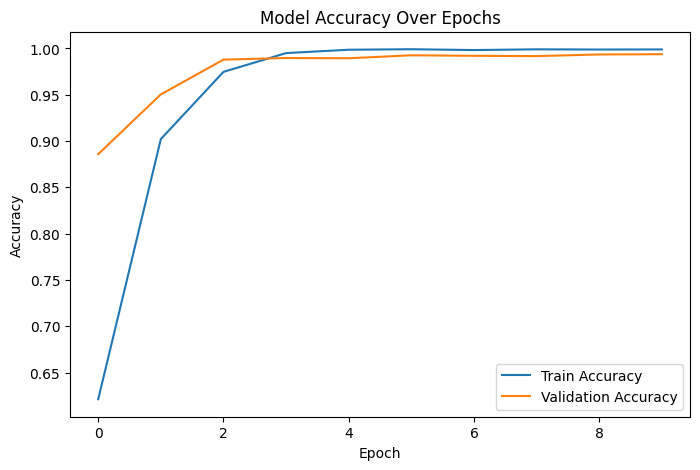

In [9]:
# Accuracy
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



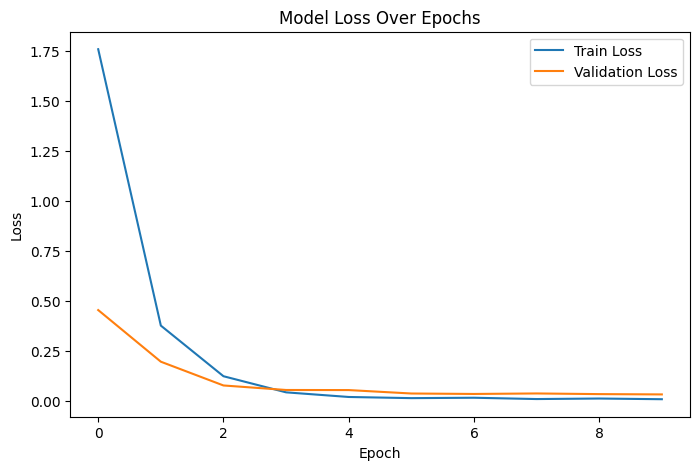

In [10]:
# Loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [11]:
test_loss, test_acc = model.evaluate(test_ds, verbose=1)
print(f"Test Accuracy: {test_acc*100:.2f}%")


117/117 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - accuracy: 0.9945 - loss: 0.0245
Test Accuracy: 99.46%
